In [2]:
import shioaji as sj
import pysimulation

api = sj.Shioaji(simulation=True)
accounts = api.login(
    api_key="",
    secret_key=""
)

2023-05-01 20:13:49.319 | WARNING  | importlib._bootstrap:_call_with_frames_removed:219 - Optional: pip install shioaji[speed] for better performance.


Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


In [2]:
import datetime
import pandas as pd
from backtesting.lib import OHLCV_AGG

days = 368

# last_days = datetime.datetime.now() - datetime.timedelta(days=days)
last_days = datetime.datetime(2022, 4, 14)

kbars = api.kbars(
    contract=api.Contracts.Futures.TXF.TXFR1, 
    start=last_days.strftime("%Y-%m-%d"), 
    end=last_days.strftime("%Y-%m-%d"),
)

df = pd.DataFrame({**kbars})
df.ts = pd.to_datetime(df.ts)
df = df.set_index('ts')
df.index.name = None
df_1min = df

for i in range(days-1):
    date = last_days + datetime.timedelta(days=i+1)
    print(date.strftime("%Y-%m-%d"))
    kbars = api.kbars(
        contract=api.Contracts.Futures.TXF.TXFR1, 
        start=date.strftime("%Y-%m-%d"), 
        end=date.strftime("%Y-%m-%d"),
    )
    if kbars['ts'] != []:
        df = pd.DataFrame({**kbars})
        df.ts = pd.to_datetime(df.ts)
        df = df.set_index('ts')
        df.index.name = None
        df_1min = pd.concat([df_1min, df], axis=0)

df_1min = df_1min.between_time('08:45:00', '13:45:01')
df_1min = df_1min[['Open', 'High', 'Low', 'Close', 'Volume']]
df_1min.to_csv('TXF_1min.csv')

'''
df = pd.read_csv(f"TXF_1min.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df = df.resample('5T', label='right').agg(OHLCV_AGG).dropna()
'''

2022-04-15
2022-04-16
2022-04-17
2022-04-18
2022-04-19
2022-04-20
2022-04-21
2022-04-22
2022-04-23
2022-04-24
2022-04-25
2022-04-26
2022-04-27
2022-04-28
2022-04-29
2022-04-30
2022-05-01
2022-05-02
2022-05-03
2022-05-04
2022-05-05
2022-05-06
2022-05-07
2022-05-08
2022-05-09
2022-05-10
2022-05-11
2022-05-12
2022-05-13
2022-05-14
2022-05-15
2022-05-16
2022-05-17
2022-05-18
2022-05-19
2022-05-20
2022-05-21
2022-05-22
2022-05-23
2022-05-24
2022-05-25
2022-05-26
2022-05-27
2022-05-28
2022-05-29
2022-05-30
2022-05-31
2022-06-01
2022-06-02
2022-06-03
2022-06-04
2022-06-05
2022-06-06
2022-06-07
2022-06-08
2022-06-09
2022-06-10
2022-06-11
2022-06-12
2022-06-13
2022-06-14
2022-06-15
2022-06-16
2022-06-17
2022-06-18
2022-06-19
2022-06-20
2022-06-21
2022-06-22
2022-06-23
2022-06-24
2022-06-25
2022-06-26
2022-06-27
2022-06-28
2022-06-29
2022-06-30
2022-07-01
2022-07-02
2022-07-03
2022-07-04
2022-07-05
2022-07-06
2022-07-07
2022-07-08
2022-07-09
2022-07-10
2022-07-11
2022-07-12
2022-07-13
2022-07-14

'\ndf = pd.read_csv(f"TXF_1min.csv", index_col=0)\ndf.index = pd.to_datetime(df.index)\ndf = df.resample(\'5T\', label=\'right\').agg(OHLCV_AGG).dropna()\n'

In [3]:
import datetime
import pandas as pd
import os
from backtesting.lib import OHLCV_AGG

df = pd.read_csv(f"TXF_1min.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df_5min = df.resample('5T', label='right', closed='right').agg(
    {'Open'  :'first',
     'High'  :'max',
     'Low'   :'min',
     'Close' :'last',
     'Volume':'sum'
    })
df_5min.dropna(axis=0, inplace=True)

In [4]:
from backtesting import Strategy
from backtesting.lib import crossover, cross
import talib as ta
from datetime import time



class myStrategy(Strategy): 
    adx_period = 30
    rsi_period = 22
    overbought = 70
    oversold = 30

    def init(self):
        self.adx = self.I(ta.ADX, self.data.High, self.data.Low, self.data.Close, self.adx_period)
        self.rsi = self.I(ta.RSI, self.data.Close, self.rsi_period)
        self.slope = self.I(ta.LINEARREG_SLOPE, self.data.Close, self.rsi_period)
        self.rsi_slope = self.I(ta.LINEARREG_SLOPE, self.rsi, self.rsi_period)
    def next(self):
        condition1 = self.data.index[-1].time() < datetime.time(13, 15)
        condition2 = self.data.index[-1].time() > datetime.time(9, 15)
        condition3 = self.data.index[-1].time() >= datetime.time(13, 25)
        condition4 = (self.data.Close[-1]>self.data.Open[-1]) and (self.data.Close[-2]>self.data.Open[-2]) and (self.data.Close[-3]>self.data.Open[-3]) # three up kbars
        condition5 = (self.data.Close[-1]<self.data.Open[-1]) and (self.data.Close[-2]<self.data.Open[-2]) and (self.data.Close[-3]<self.data.Open[-3]) # three down kbars
        condition6 = (self.rsi[-2:] > self.overbought).all() # rsi overbought
        condition7 = (self.rsi[-2:] < self.oversold).all() # rsi oversold
        condition8 = self.slope[-1] > 0 # price slope > 0
        condition9 = self.slope[-1] < 0 # price slope < 0
        # condition10 = self.adx[-2:] >= 20 # adx > 20
        condition11 = (self.adx[-2:] < 20).all() # adx < 20
        # condition12 = (self.rsi[-2]<overbought) and (self.rsi[-1]>=overbought) # rsi crossover overbought
        condition13 = (self.rsi[-2]>self.overbought) and (self.rsi[-1]<=self.overbought) # rsi crossdown overbought
        # condition14 = (self.rsi[-2]>self.oversold) and (self.rsi[-1]<=self.oversold) # rsi crossdown oversold
        condition15 = (self.rsi[-2]<self.oversold) and (self.rsi[-1]>=self.oversold) # rsi crossover oversold
        condition16 = (self.adx[-2]<25) and (self.adx[-1]>=25) # adx crossover 25
        condition17 = (self.adx[-2]>25) and (self.adx[-1]<=25) # adx crossdown 25
        condition18 = (self.adx[-2:] >= 30).all() # adx > 30
        # condition19 = self.adx[-2:] < 30 # adx < 30
        condition20 = self.rsi_slope[-1] > 0 # rsi slope > 0
        condition21 = self.rsi_slope[-1] < 0 # rsi slope < 0
        condition22 = (self.adx[-2:] >= 25).all() # adx > 25
        # operating time : 9:15~13:05, stop loss = 0.4%, take profit = 3%
        if not self.position:
            if condition1 and condition2: # 9:15 ~ 13:15
                if condition13 and (condition18 or condition16):
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.035))
                elif condition15 and (condition18 or condition16):
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.035))
                elif self.rsi[-1]>=45 and condition22 and condition8 and condition20:
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.035))
                elif self.rsi[-1]<=55 and condition22 and condition9 and condition21:
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.035))
                elif condition22 and condition9 and condition20:
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.035))
                elif condition22 and condition8 and condition21:
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.035))
                    
        elif self.position.is_long:
            if condition1 and condition2: # 9:15 ~ 13:15
                if condition6 and (condition11 or condition17):
                    self.position.close()
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.035))
                elif self.rsi[-1]<=55 and condition22 and condition9 and condition21:
                    self.position.close()
                    self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.035))
                elif condition5:
                    self.position.close()
                    if condition22:
                        self.sell(size=200, sl=self.data.Close[-1]*(1+0.007), tp=self.data.Close[-1]*(1-0.035))
            elif condition3:
                self.position.close()
                
        elif self.position.is_short:
            if condition1 and condition2: # 9:15 ~ 13:15
                if condition7 and (condition11 or condition17):
                    self.position.close() 
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.035))
                elif self.rsi[-1]>45 and condition22 and condition8 and condition20:
                    self.position.close() 
                    self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.035))
                elif condition4:
                    self.position.close() 
                    if condition22:
                        self.buy(size=200, sl=self.data.Close[-1]*(1-0.007), tp=self.data.Close[-1]*(1+0.035))
            elif condition3:
                self.position.close()

In [5]:
from backtesting import Backtest

bt = Backtest(df_5min, myStrategy, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
stats = bt.run()
print(stats)
bt.plot(resample=False)

Start                     2022-04-14 08:50:00
End                       2023-04-14 13:45:00
Duration                    365 days 04:55:00
Exposure Time [%]                   34.303279
Equity Final [$]                  654083.6448
Equity Peak [$]                   726888.3072
Return [%]                          30.816729
Buy & Hold Return [%]               -7.959137
Return (Ann.) [%]                   31.973979
Volatility (Ann.) [%]               50.339077
Sharpe Ratio                         0.635172
Sortino Ratio                        1.356126
Calmar Ratio                         1.437095
Max. Drawdown [%]                  -22.249033
Avg. Drawdown [%]                   -1.755554
Max. Drawdown Duration      184 days 22:20:00
Avg. Drawdown Duration        4 days 20:49:00
# Trades                                  448
Win Rate [%]                        40.848214
Best Trade [%]                       1.706686
Worst Trade [%]                     -0.717167
Avg. Trade [%]                    

Row(id='1678', ...)

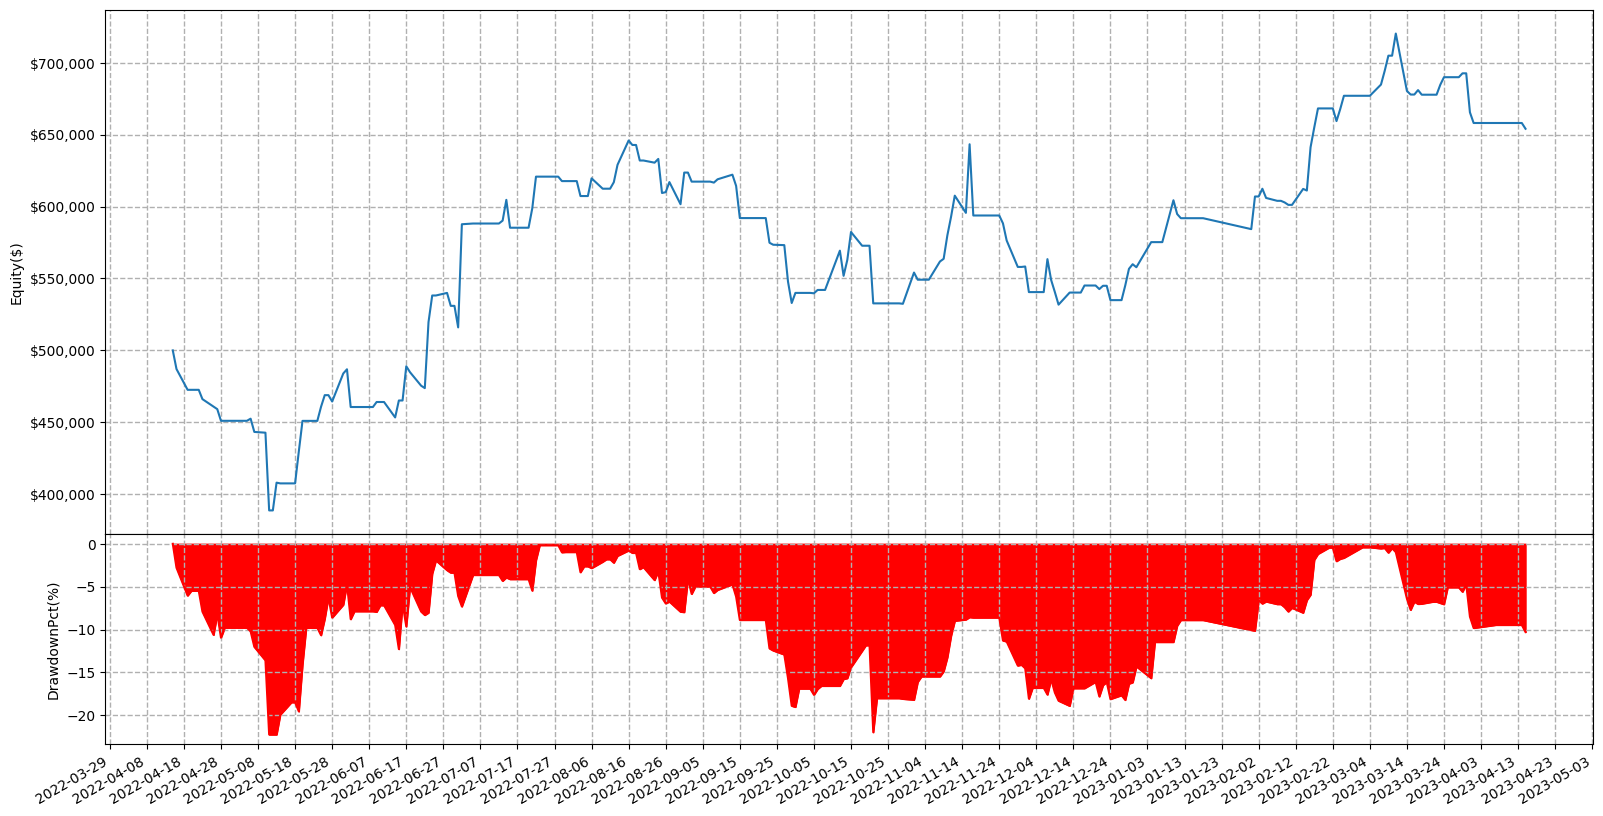

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

equity_data = stats._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

ax1.grid(linestyle = '--', linewidth = 1)
ax1.plot(equity_data['Equity'])
ax1.set(ylabel="Equity($)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.grid(linestyle = '--', linewidth = 1)
ax2.plot(equity_data['DrawdownPct'], color="red")
ax2.set(ylabel="DrawdownPct(%)")
ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
f.subplots_adjust(hspace=0)
f.autofmt_xdate()

plt.show()

Start                     2022-11-21 08:50:00
End                       2023-04-14 13:45:00
Duration                    144 days 04:55:00
Exposure Time [%]                   33.461538
Equity Final [$]                  559495.4324
Equity Peak [$]                   632300.0948
Return [%]                          11.899086
Buy & Hold Return [%]                9.986896
Return (Ann.) [%]                   36.524929
Volatility (Ann.) [%]               42.046921
Sharpe Ratio                         0.868671
Sortino Ratio                        1.890723
Calmar Ratio                         2.546394
Max. Drawdown [%]                  -14.343787
Avg. Drawdown [%]                   -1.260132
Max. Drawdown Duration       46 days 02:05:00
Avg. Drawdown Duration        2 days 16:40:00
# Trades                                  162
Win Rate [%]                        44.444444
Best Trade [%]                       0.969196
Worst Trade [%]                     -0.626589
Avg. Trade [%]                    

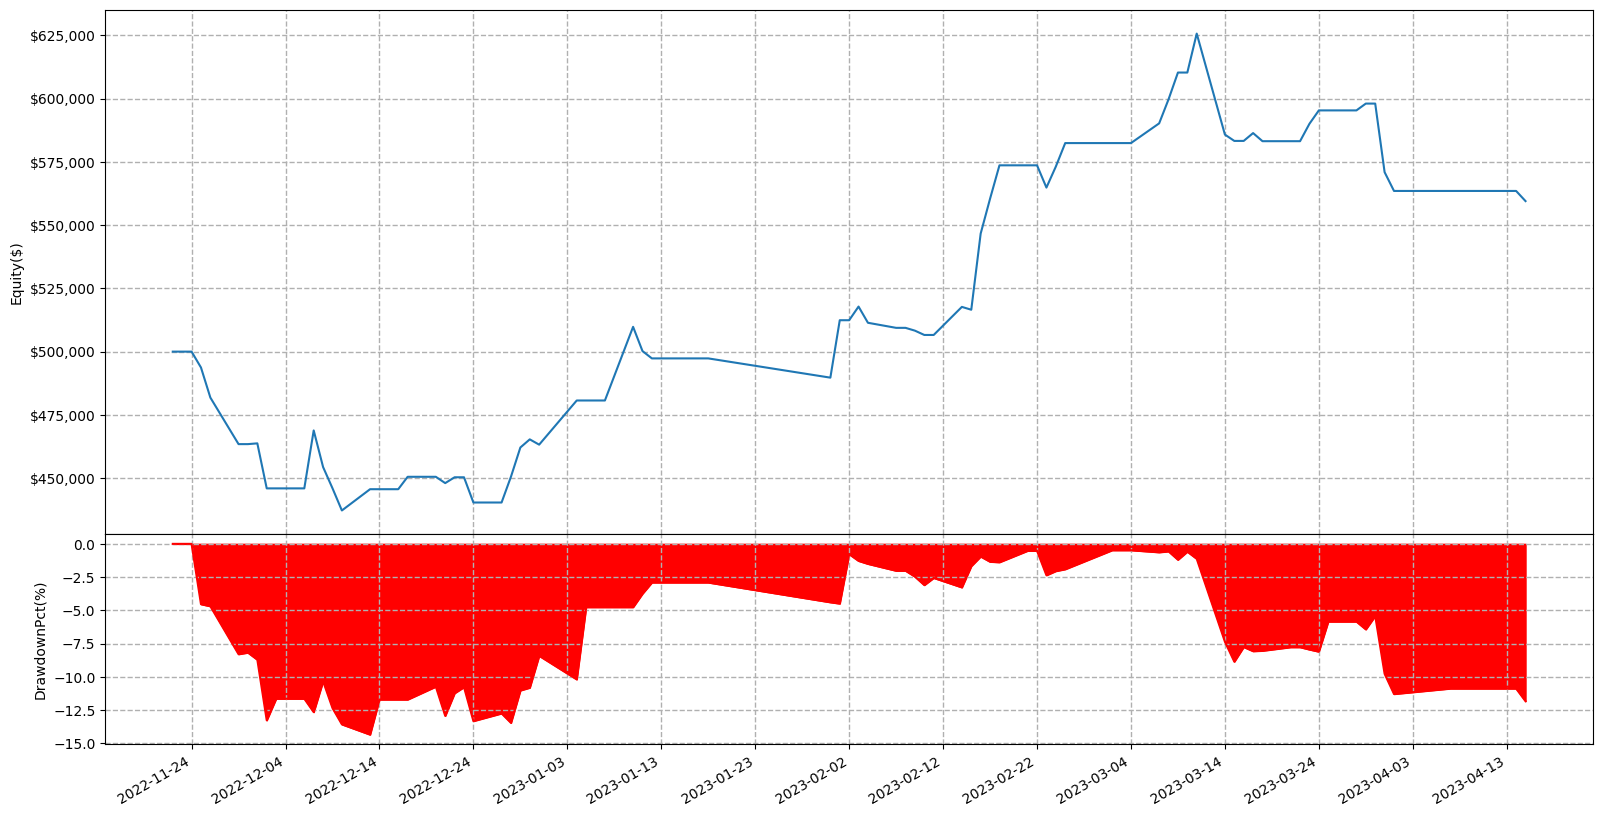

In [6]:
df_out_sample = df_5min[df_5min.index > '2022-11-20']
bt_out = Backtest(df_out_sample, myStrategy, cash=500_000, commission=0.000033, hedging=False, exclusive_orders=False, margin=0.05)
stats_out = bt_out.run()
print(stats_out)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter
from backtesting.lib import _EQUITY_AGG

equity_data = stats_out._equity_curve.resample('1D', label='right').agg(_EQUITY_AGG).dropna(how='all')
equity_data['DrawdownPct'] = equity_data['DrawdownPct'].multiply(-100)

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(19.2, 10.8), gridspec_kw={'height_ratios': [5, 2]})

ax1.grid(linestyle = '--', linewidth = 1)
ax1.plot(equity_data['Equity'])
ax1.set(ylabel="Equity($)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax2.grid(linestyle = '--', linewidth = 1)
ax2.plot(equity_data['DrawdownPct'], color="red")
ax2.set(ylabel="DrawdownPct(%)")
ax2.fill_between(equity_data['DrawdownPct'].index, equity_data['DrawdownPct'], where=(equity_data['DrawdownPct'] <= 0), color="red")   
f.subplots_adjust(hspace=0)
f.autofmt_xdate()

plt.show()